In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from ema_workbench.analysis import parcoords

plt.rcParams['figure.figsize'] = [20, 10]
plt.rcParams['figure.dpi'] = 200
sns.set(font_scale=1.5)
#plt.rcParams["font.family"] = "Times New Roman"
#plt.rcParams["font.size"] = "50"

from ema_workbench import (Model, RealParameter, ScalarOutcome, load_results)

# Import model
from problem_formulation import get_model_for_problem_formulation

# Get model instance
model, steps = get_model_for_problem_formulation(3)
#outcomes = model.outcomes

# Analyze robustness of  policies
For this, the experiments that were executed for the policies resulting from MORDM are imported and analyzed

In [2]:
# Load experiments performed for policies
fn = 'SECOND candidate solutions MORDM 1000scenarios.tar.gz'

try:
    # Store results in dataframe
    results = load_results(fn)
except IOError:
    print("Error loading data")


experiments, outcomes = results
experiments


,A.0_ID flood wave shape,A.1_Bmax,A.1_Brate,A.1_pfail,A.2_Bmax,A.2_Brate,A.2_pfail,A.3_Bmax,A.3_Brate,A.3_pfail,...,A.3_DikeIncrease 2,A.4_DikeIncrease 0,A.4_DikeIncrease 1,A.4_DikeIncrease 2,A.5_DikeIncrease 0,A.5_DikeIncrease 1,A.5_DikeIncrease 2,scenario,policy,model
0,45.0,334.338219,1.5,0.384455,48.791951,1.5,0.243866,332.087341,10.0,0.272985,...,2.0,7.0,1.0,0.0,4.0,0.0,0.0,0,277,dikesnet
1,115.0,167.703202,10.0,0.443832,57.738115,1.0,0.350760,123.453385,1.5,0.678659,...,2.0,7.0,1.0,0.0,4.0,0.0,0.0,1,277,dikesnet
2,67.0,40.526313,10.0,0.844840,84.297462,1.0,0.032855,88.744746,1.5,0.004323,...,2.0,7.0,1.0,0.0,4.0,0.0,0.0,2,277,dikesnet
3,77.0,82.259809,10.0,0.305028,116.595805,10.0,0.020959,342.847398,10.0,0.614126,...,2.0,7.0,1.0,0.0,4.0,0.0,0.0,3,277,dikesnet
4,3.0,184.237540,1.0,0.656921,88.684076,1.5,0.509033,308.089112,1.5,0.472518,...,2.0,7.0,1.0,0.0,4.0,0.0,0.0,4,277,dikesnet
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,118.0,282.821093,1.5,0.967233,305.865774,10.0,0.595073,134.562129,10.0,0.690778,...,5.0,4.0,1.0,0.0,0.0,1.0,8.0,995,1221,dikesnet
4996,57.0,116.401613,1.0,0.556346,228.639140,1.0,0.804866,104.696299,10.0,0.905073,...,5.0,4.0,1.0,0.0,0.0,1.0,8.0,996,1221,dikesnet
4997,77.0,31.414723,1.5,0.719013,249.616704,10.0,0.442115,154.844832,1.5,0.583364,...,5.0,4.0,1.0,0.0,0.0,1.0,8.0,997,1221,dikesnet
4998,64.0,279.145699,1.0,0.447402,227.117475,10.0,0.153103,242.091600,1.0,0.739549,...,5.0,4.0,1.0,0.0,0.0,1.0,8.0,998,1221,dikesnet


Now, we  evaluate the **robustness** of each of the policy options based on these scenario results. We can calculate the robustness of a policy option in terms of its performance on an outcome indicator across the 1000 scenarios. In other words, we can identify how robust a policy is in terms of each outcome indicator, and investigate the robustness tradeoffs.

**The following function calculates the signal-to-noise ratio for the outcome indicators.**

In [3]:
def s_to_n(data, direction):
    mean = np.mean(data)
    std = np.std(data)
    
    if direction==ScalarOutcome.MAXIMIZE:
        return mean/std
    else:
        return mean*std

There are various ways in which we could calculate the signal to noise ratio. Here, I choose to iterate over the policy first. Next, I iterate over the outcomes. For each outcome, I only retrieve the results associated with the current policy. Next, I can calculate the signal to noise ratio. 

I am reusing the direction that we already specified for each outcome of interest, to avoid duplicating code. Note that I enabled this already with how I defined the s_to_n function above.

To make visualization easy, I transform all my results into a dataframe at the end.

In [4]:
overall_scores = {}
for policy in np.unique(experiments['policy']):
    scores = {}
    
    logical = experiments['policy']==policy
    
    for outcome in model.outcomes:
        value  = outcomes[outcome.name][logical]
        sn_ratio = s_to_n(value, outcome.kind)
        scores[outcome.name] = sn_ratio
    overall_scores[policy] = scores
scores = pd.DataFrame.from_dict(overall_scores).T
scores

,A.1 Total Costs,A.1_Expected Number of Deaths,A.2 Total Costs,A.2_Expected Number of Deaths,A.3 Total Costs,A.3_Expected Number of Deaths,A.4 Total Costs,A.4_Expected Number of Deaths,A.5 Total Costs,A.5_Expected Number of Deaths,RfR Total Costs,Expected Evacuation Costs
277,1.431084e+16,0.001371,1.316090e+16,3.155997e-03,2.184408e+14,0.000001,8.412778e+13,5.576651e-07,8.057435e+15,0.003903,0.0,0.000000e+00
558,1.134272e+16,0.000155,9.407406e+14,2.179096e-06,1.511880e+15,0.000743,7.744269e+14,1.467486e-04,6.292932e+15,0.002956,0.0,0.000000e+00
683,1.202797e+17,0.043725,6.149166e+15,5.432886e-04,4.197794e+15,0.001382,1.019977e+15,1.591928e-04,3.618588e+16,0.020702,0.0,0.000000e+00
832,4.996415e+16,0.000142,4.421822e+14,6.907304e-09,1.341116e+16,0.000611,2.555181e+14,2.298613e-07,2.982233e+16,0.000442,0.0,1.144495e+08
1221,2.667936e+16,0.002543,7.458378e+15,2.198999e-03,5.778961e+14,0.000009,3.434203e+14,1.797286e-05,3.751030e+16,0.019545,0.0,0.000000e+00


# Signal to noise ratio

In [5]:
colors = sns.color_palette()

data = scores

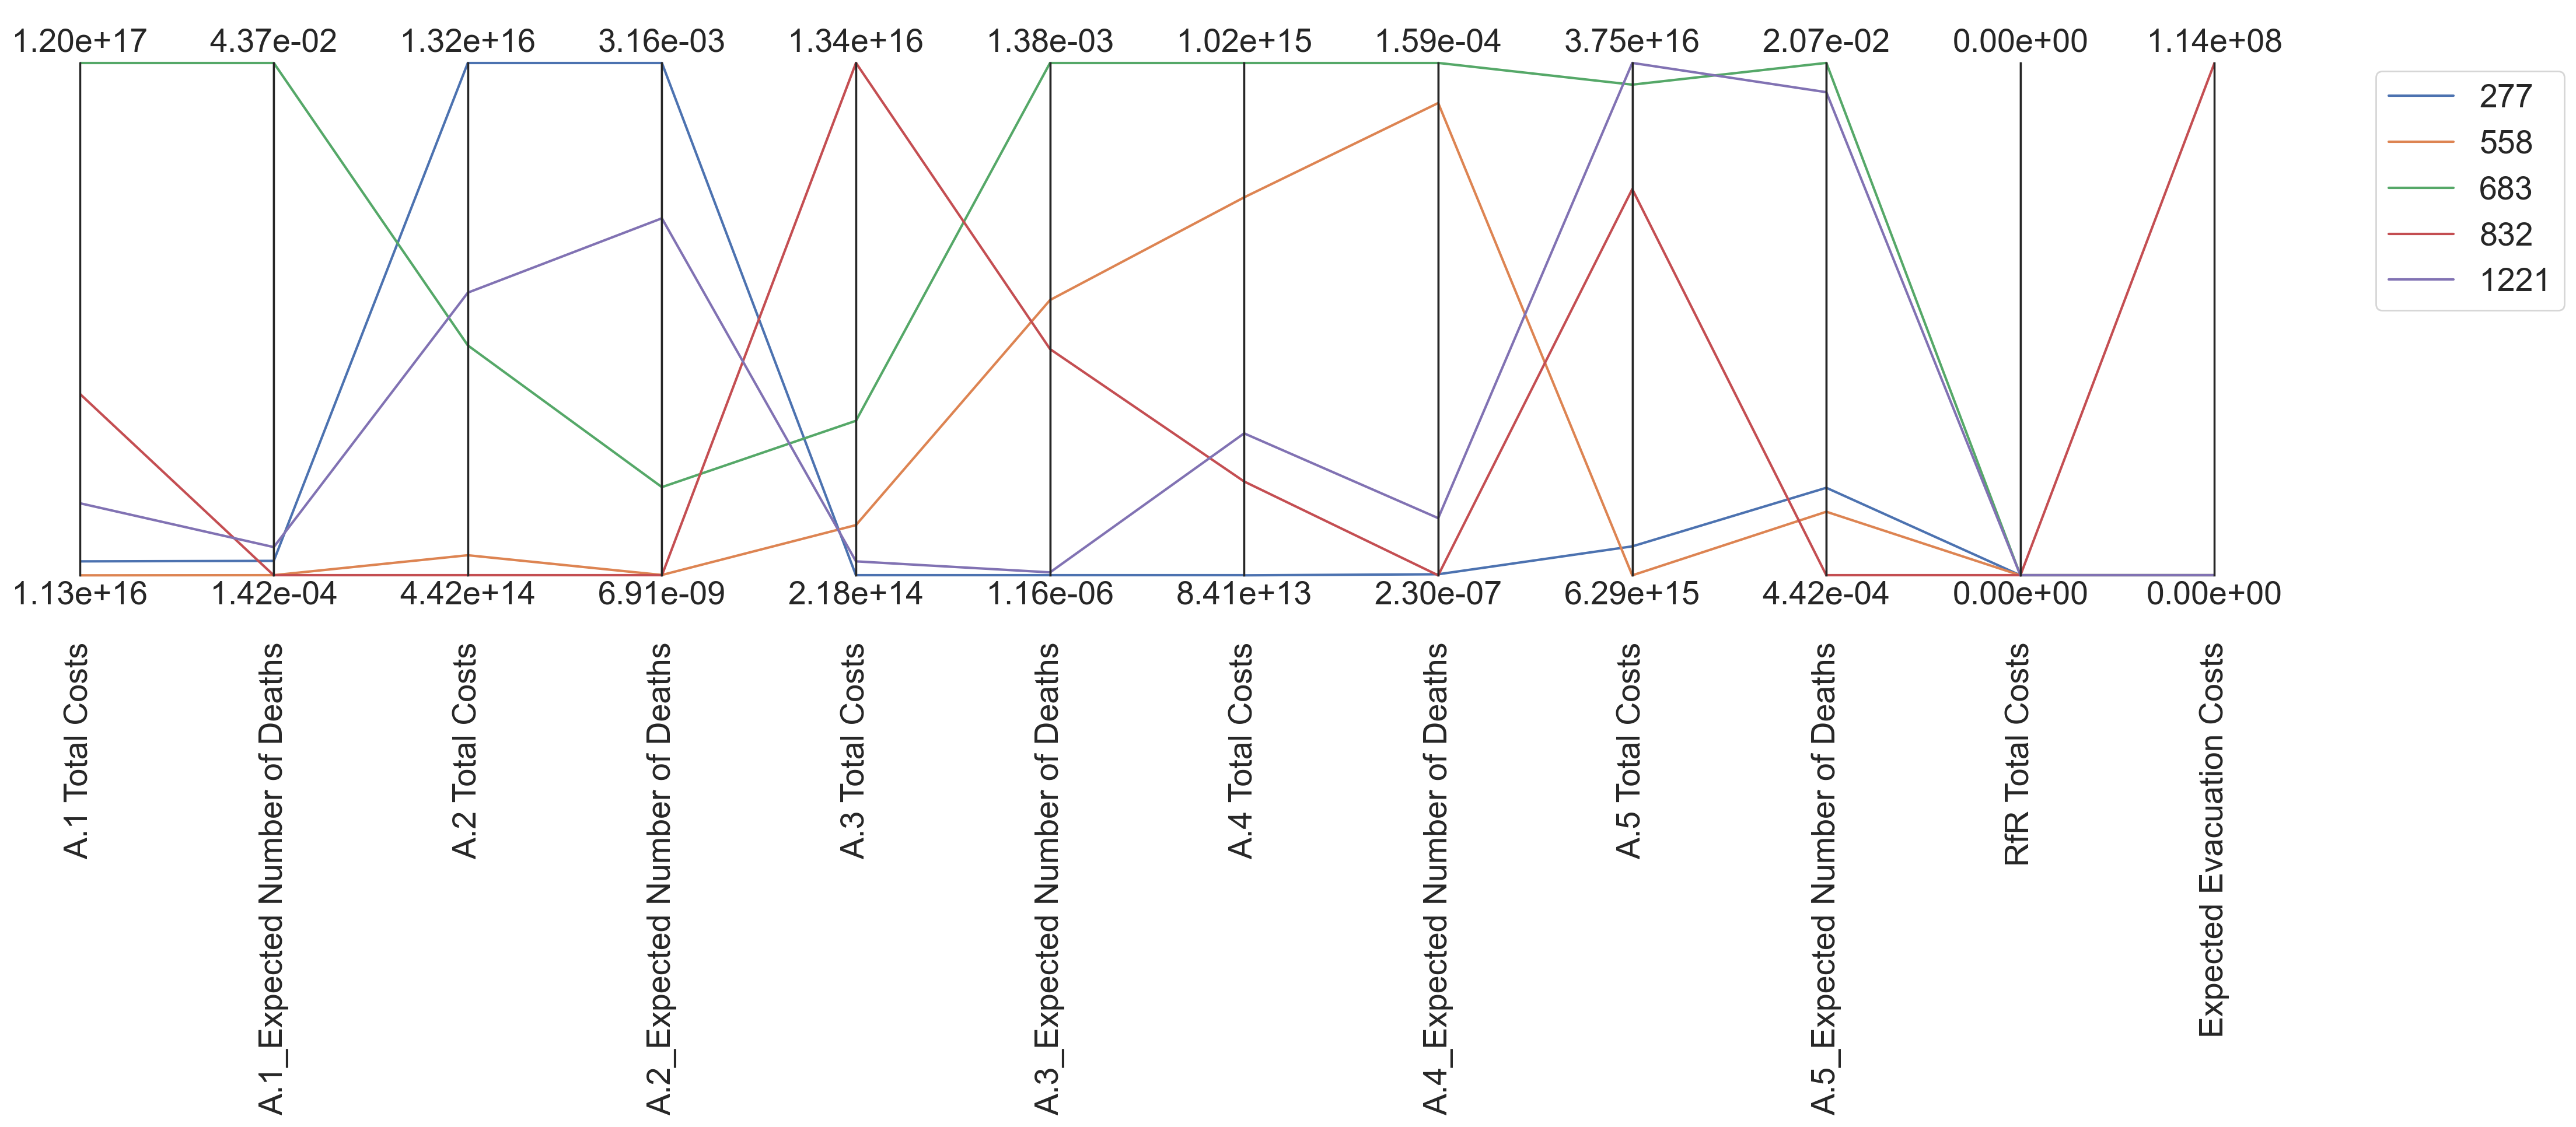

<Figure size 6000x6000 with 0 Axes>

In [6]:

# makes it easier to identify the policy associated with each line
# in the parcoords plot
# data['policy'] = data.index.astype("float64")

# Create dictionary for axis format, use scientific notation for better readiblity 
formatMinMax = {}

for outcome in model.outcomes:
    formatMinMax[outcome.name] = ".2e"

limits = parcoords.get_limits(data)
#limits.loc[0, ['utility', 'inertia', 'reliability', 'max_P']] = 0

paraxes = parcoords.ParallelAxes(limits, formatter=formatMinMax, fontsize=20)
for i, (index, row) in enumerate(data.iterrows()):
    paraxes.plot(row.to_frame().T, label=str(index), color=colors[i])
paraxes.legend()

#for outcome in model.outcomes:
#    if(outcome.kind == -1):
#        paraxes.invert_axis(outcome.name)

fig = plt.figure(figsize=(30,30))
plt.show()

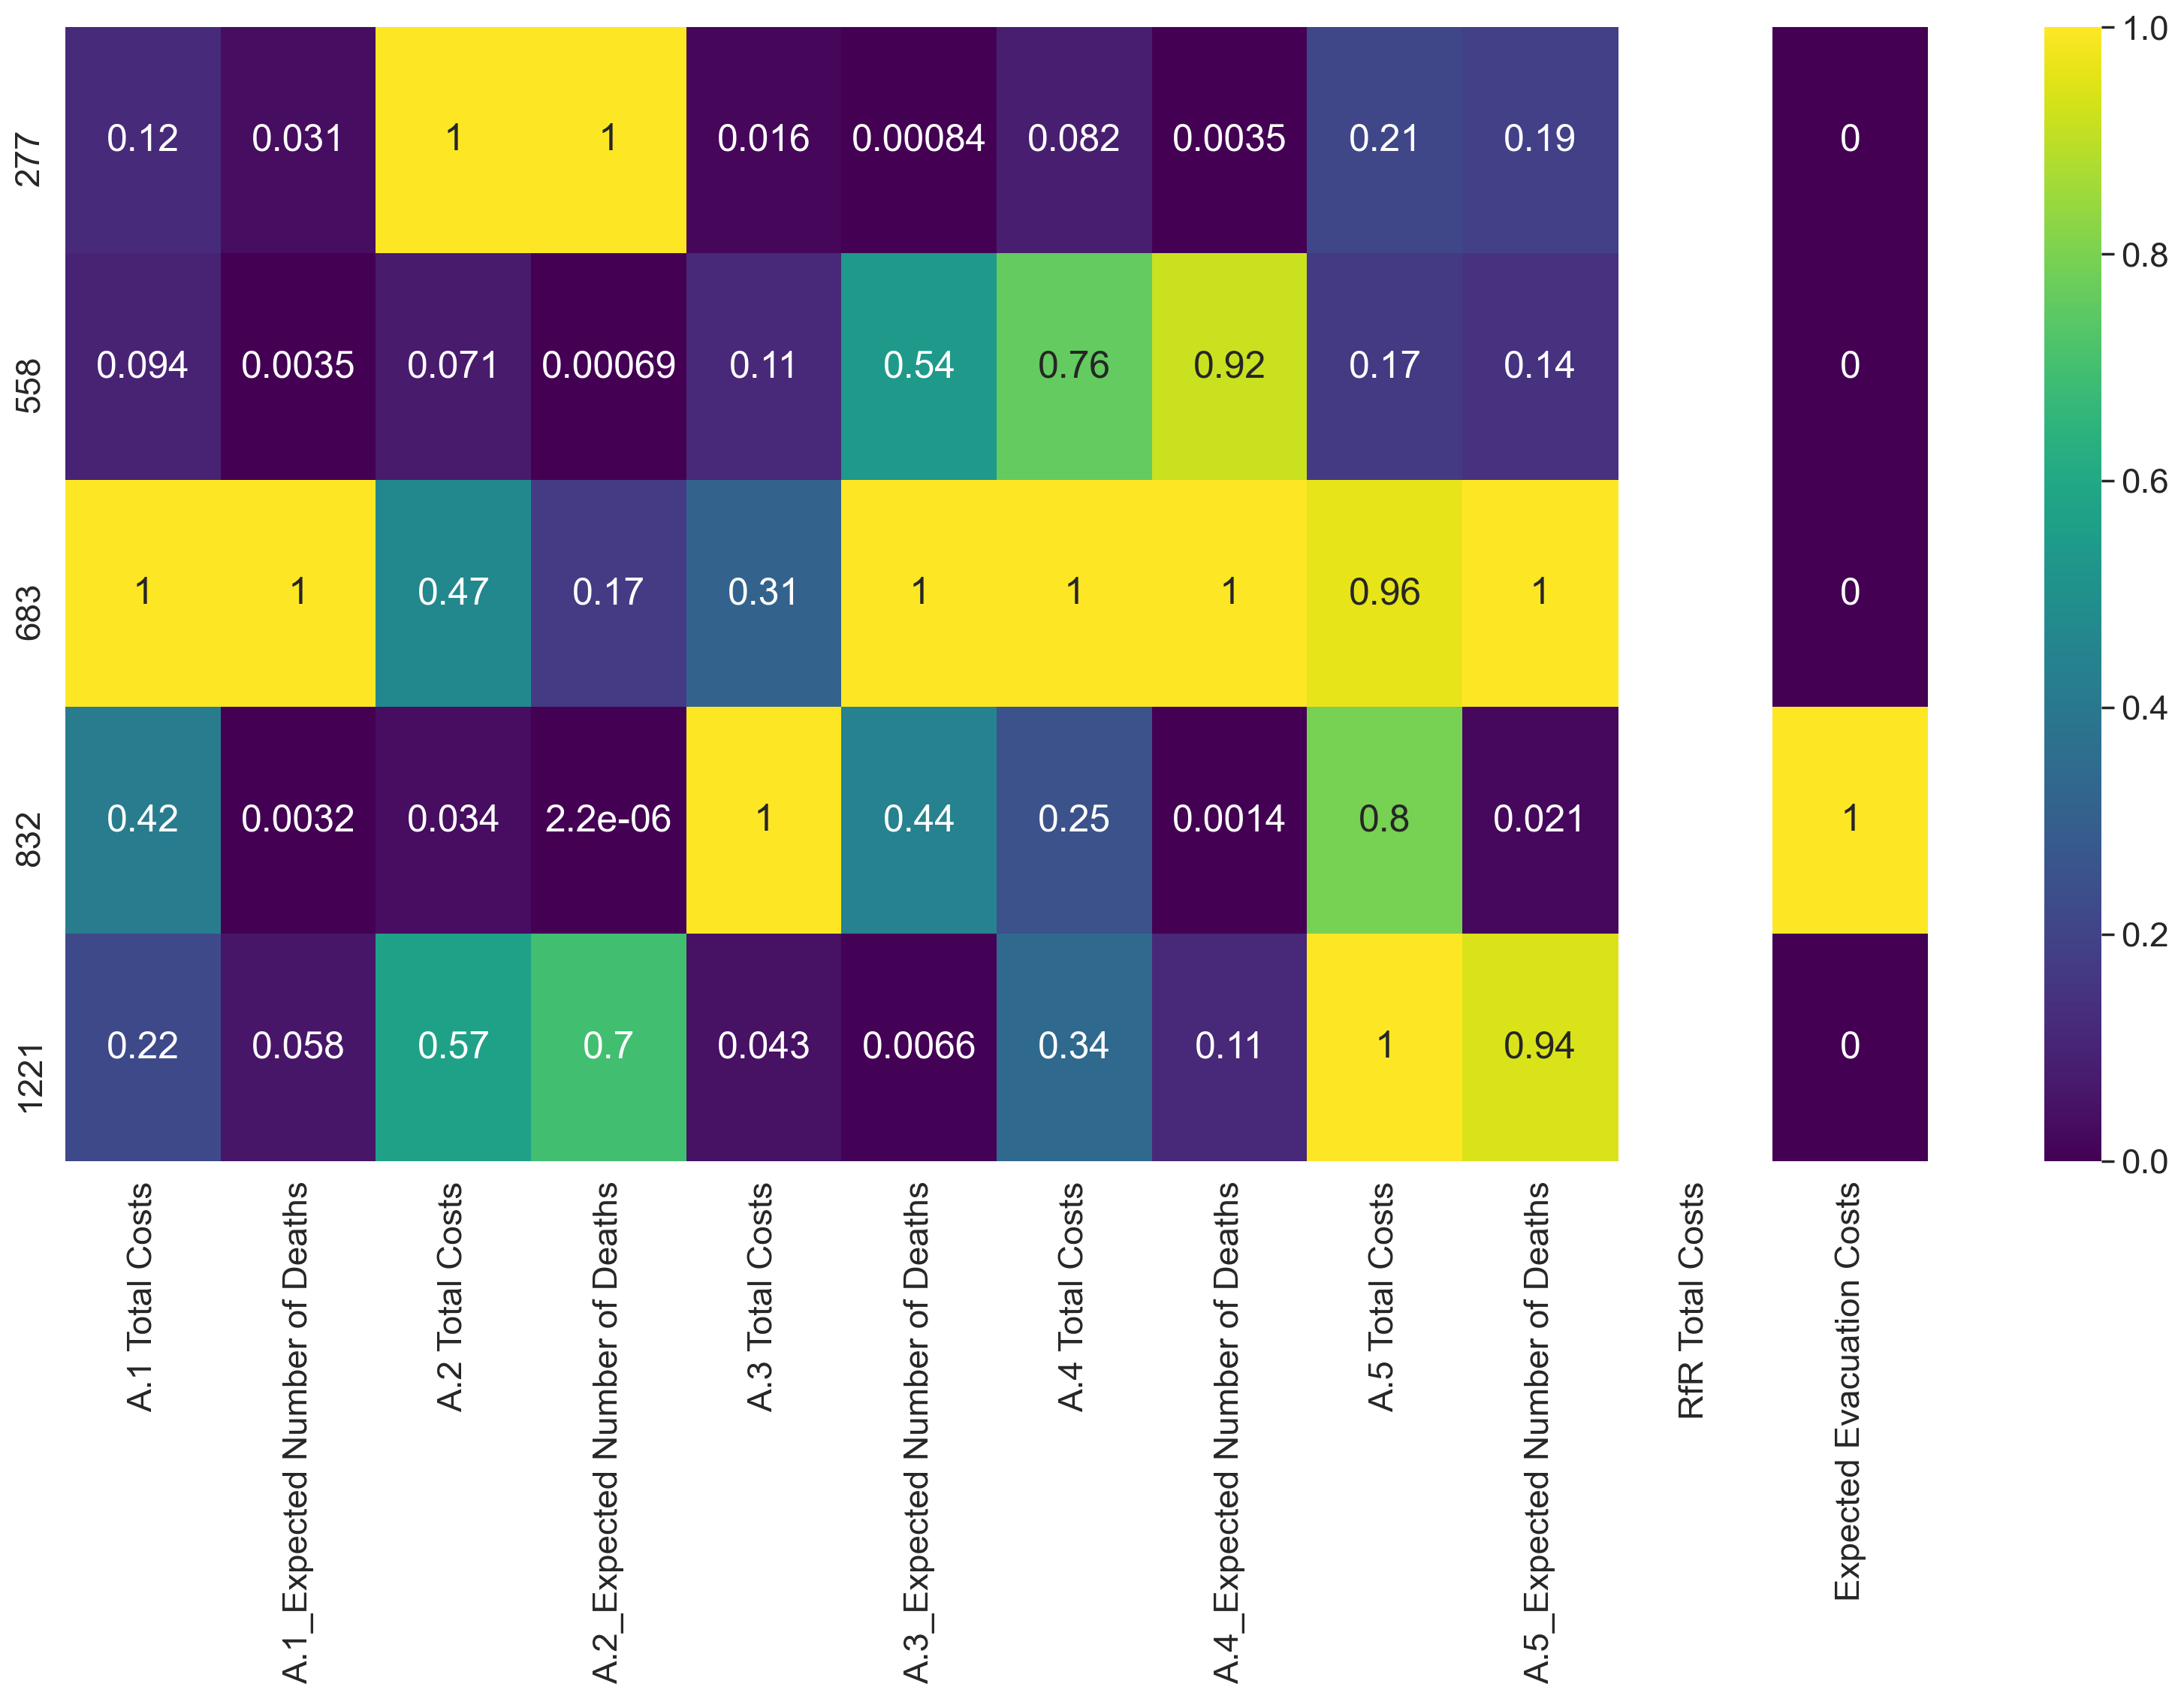

In [7]:
scores = pd.DataFrame(scores)
sns.heatmap(scores/scores.max(), cmap='viridis', annot=True)
plt.show()

An ideal solution has no room for river (RfR Total Costs = 0) and low deaths (only in Gelderland area?).

# Maximum regret

Another robustness metric is **maximum regret**, calculated again for each policy and for each outcome indicator. *Regret* is defined for each policy under each scenario, as the difference between the performance of the policy in a specific scenario and the berformance of a no-regret (i.e. best possible result in that scenario) or reference policy. The *maximum regret*  is then the maximum of such regret values across all scenarios. We of course favor policy options with low *maximum regret* values. 

**Write a function to calculate the maximum regret for both kinds of outcome indicators. Calculate the maximum regret values for each outcome and each policy option. Plot the tradeoffs on a parallel plot. Which solutions look like a good compromise policy?**

In [8]:
def calculate_regret(data, best):
    return np.abs(best-data)

Regret is the performance difference between the best possible outcome in a scenario across policies, the the observed outcome for a given policy. We have in this case both minimization and maximization. Best means the lowest in case of mimimization, and heighest in case of maximization. To avoid having to explicitly account for this in how we calculate the difference, we can simply take the absolute value of the difference. In this case, max_P will return negative regret values for `best-data`, so by taking the absolute value, we fix this

The next part of the code is probably the most tricky part. We need to find the best possible outcome for each scenario. We could do this by iterating over the scenario_id column in the experiment array. But we can also use pandas instead as done below. Wat we do is the following:
1. we create a dataframe with the outcome, the name of the policy and the scenario. This is a so called long-form representation of the data
2. We want to have the results for each policy side by side so we can take the max, or min accross the column. The pivot method on the DataFrame does this for us
3. We take the maximum or minimum accross the row.

In [9]:
experiments, outcomes = results

overall_regret = {}
max_regret = {}
for outcome in model.outcomes:
    policy_column = experiments['policy']
    
    # create a DataFrame with all the relevant information
    # i.e., policy, scenario_id, and scores
    data = pd.DataFrame({outcome.name: outcomes[outcome.name], 
                         "policy":experiments['policy'],
                         "scenario":experiments['scenario']})
    
    # reorient the data by indexing with policy and scenario id
    data = data.pivot(index='scenario', columns='policy')
    
    # flatten the resulting hierarchical index resulting from 
    # pivoting, (might be a nicer solution possible)
    data.columns = data.columns.get_level_values(1)
    
    # we need to control the broadcasting. 
    # max returns a 1d vector across scenario id. By passing
    # np.newaxis we ensure that the shape is the same as the data
    # next we take the absolute value
    #
    # basically we take the difference of the maximum across 
    # the row and the actual values in the row
    #
    outcome_regret = (data.max(axis=1)[:, np.newaxis] - data).abs()
    
    overall_regret[outcome.name] = outcome_regret
    max_regret[outcome.name] = outcome_regret.max()
    

<ipython-input-9-b2c56fe0d6eb>:29: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  outcome_regret = (data.max(axis=1)[:, np.newaxis] - data).abs()


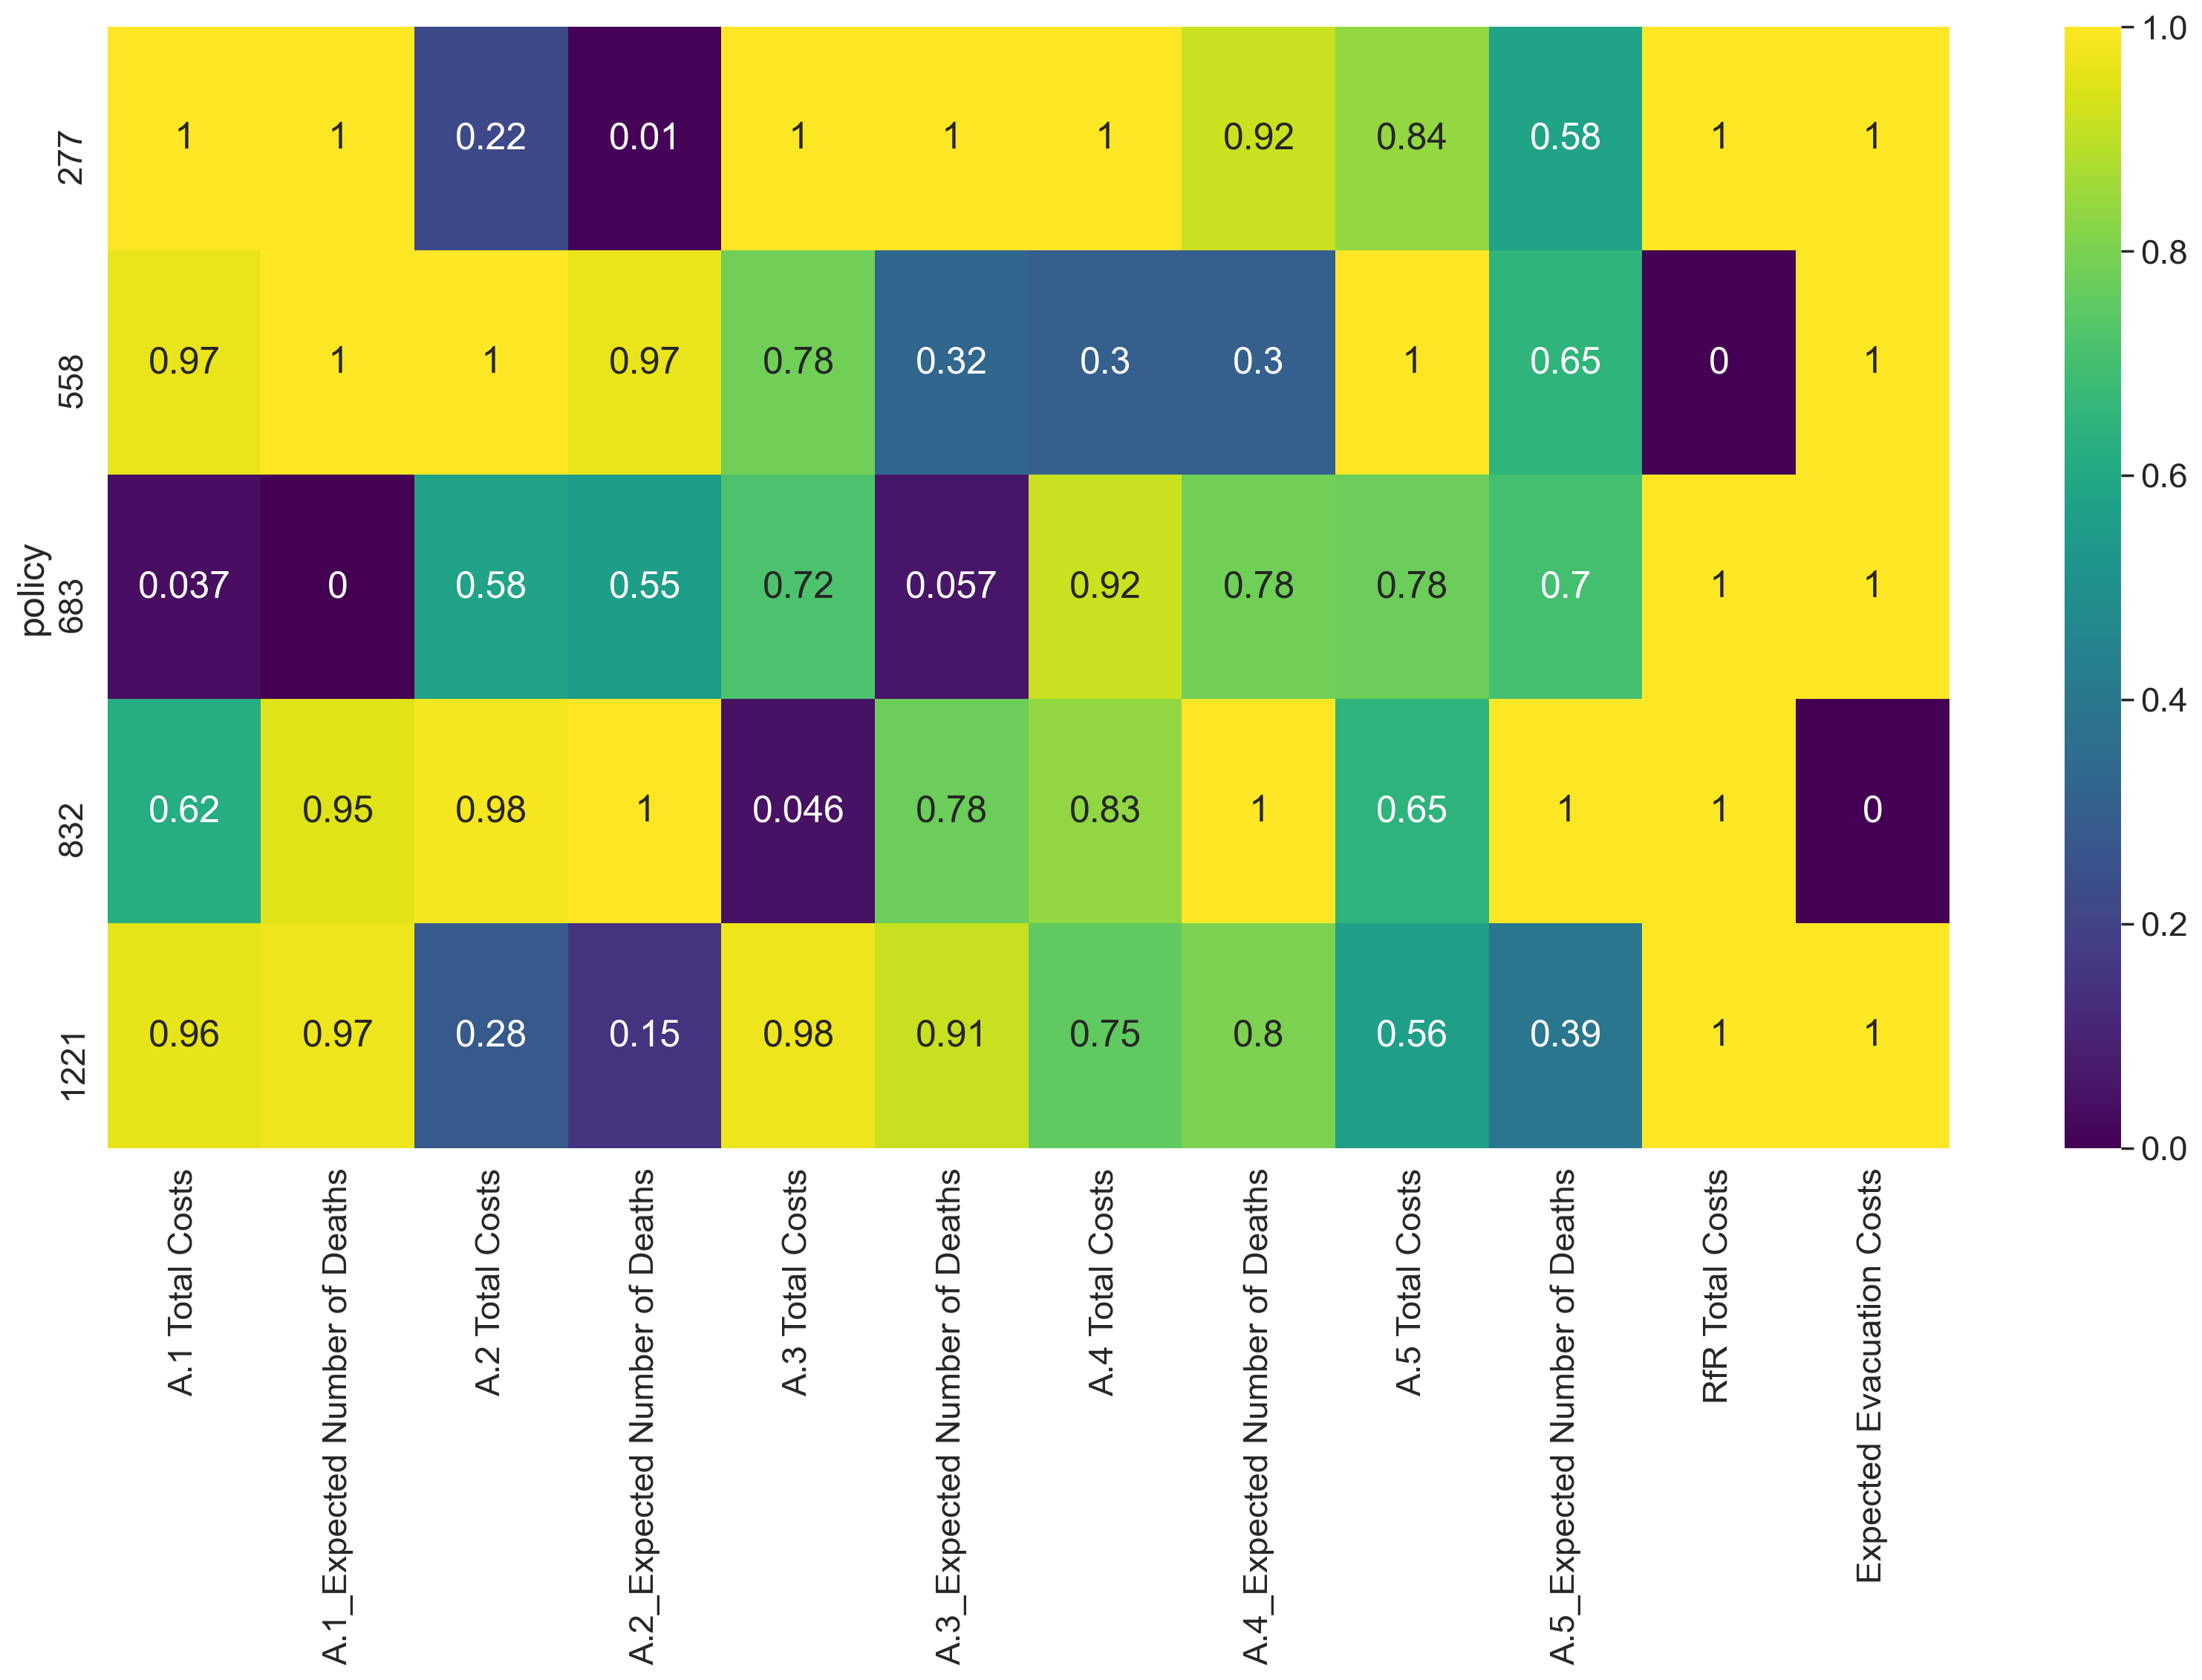

In [10]:
max_regret = pd.DataFrame(max_regret)
sns.heatmap(max_regret/max_regret.max(), cmap='viridis', annot=True)
plt.show()

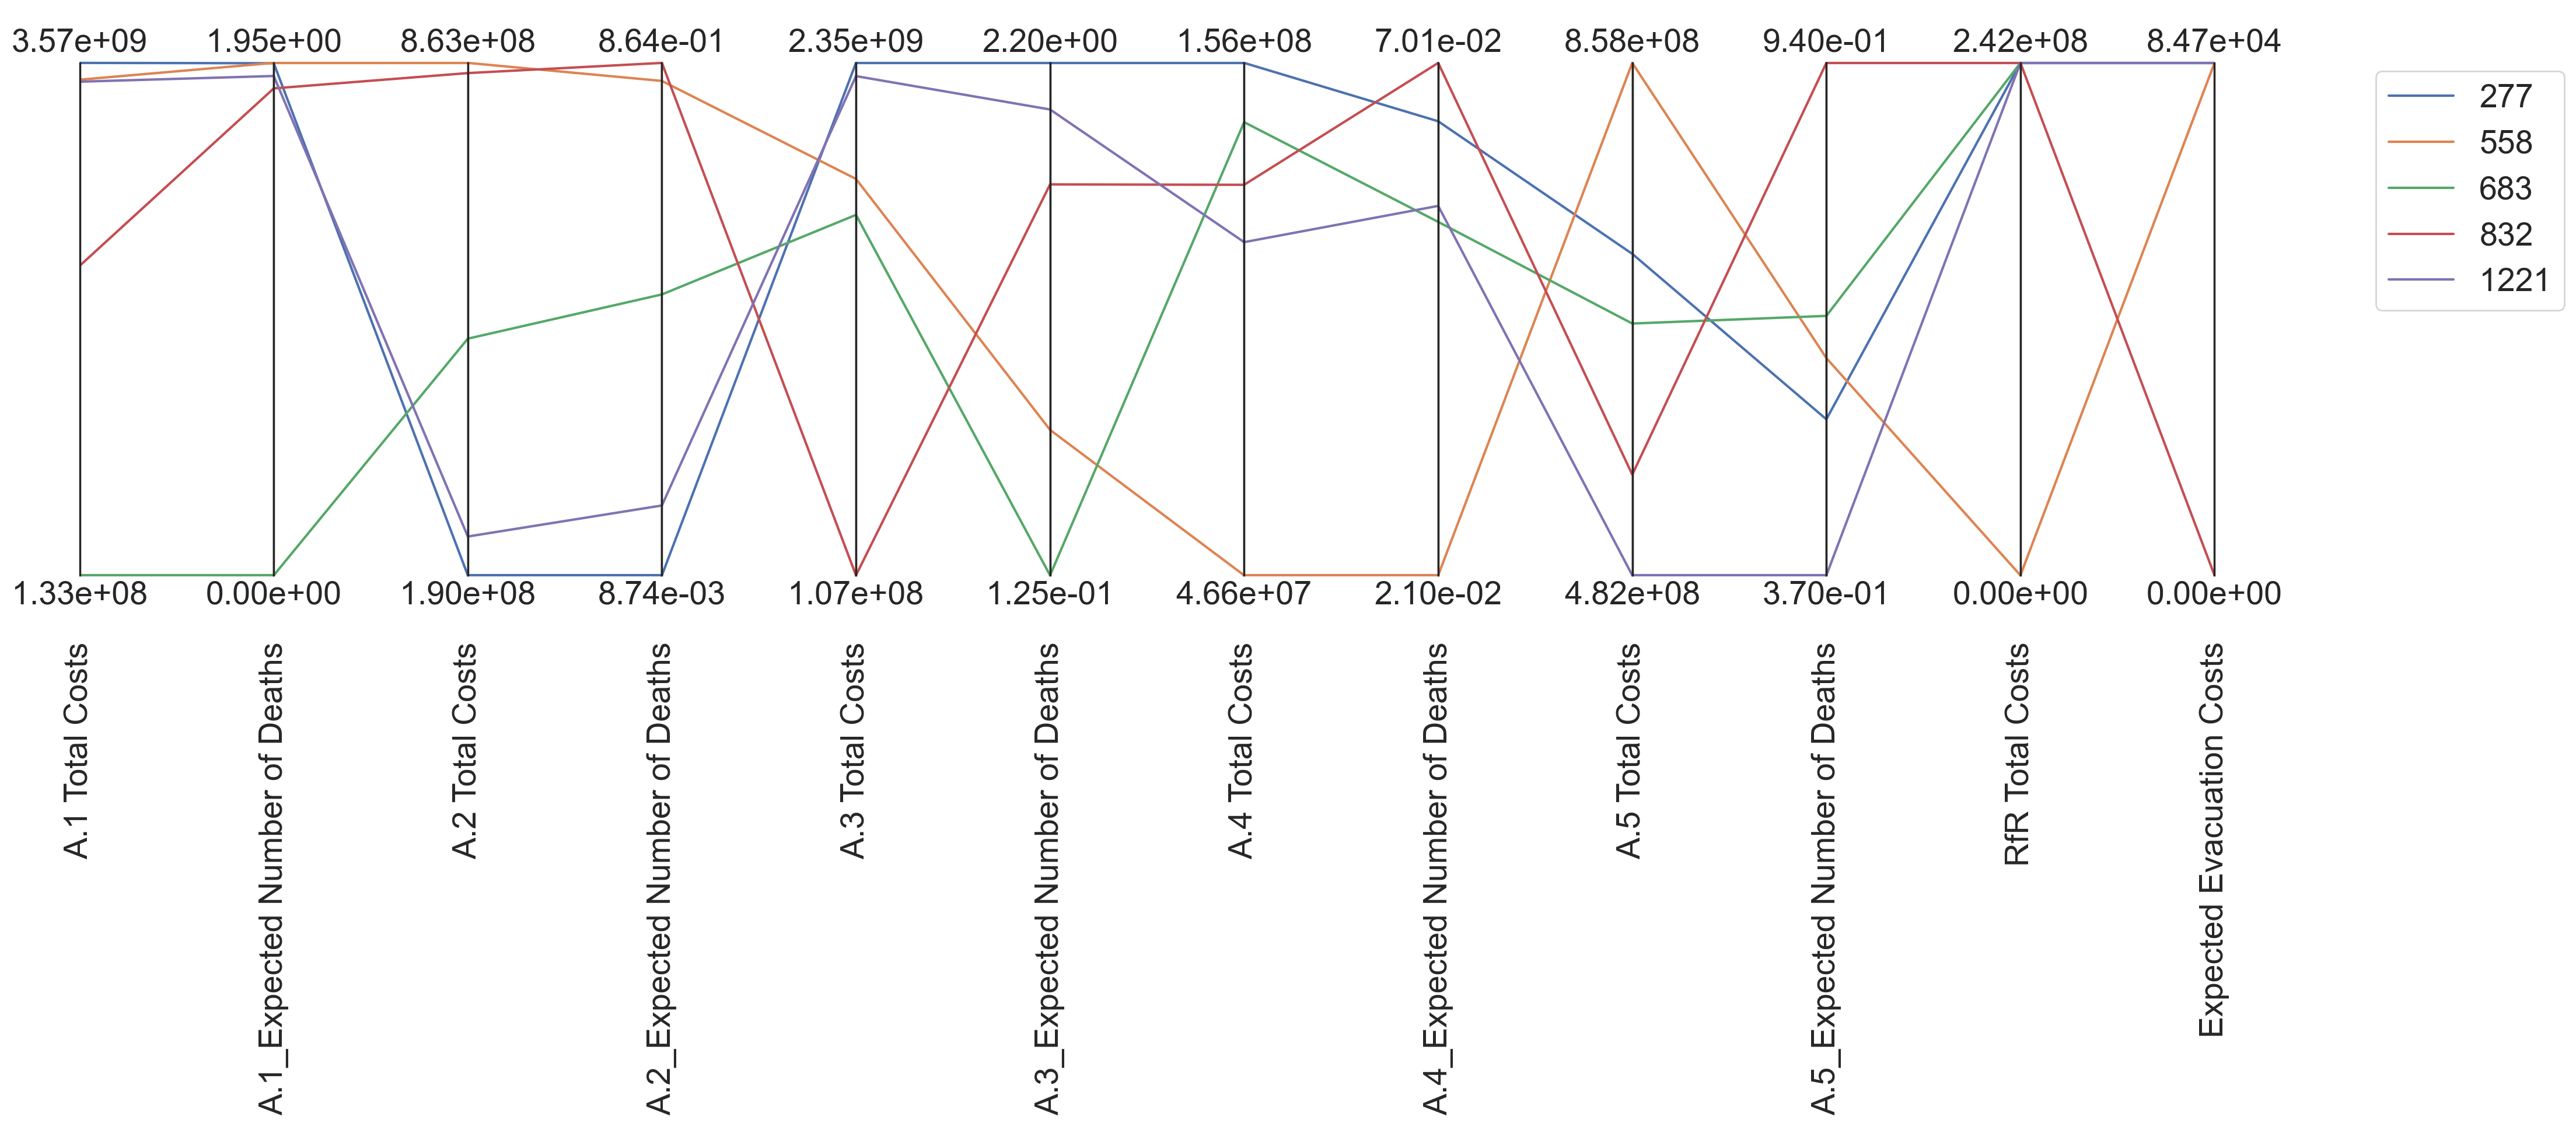

In [11]:

colors = sns.color_palette()

data = max_regret

# makes it easier to identify the policy associated with each line
# in the parcoords plot
# data['policy'] = data.index.astype("float64")

limits = parcoords.get_limits(data)
#limits.loc[0, ['utility', 'inertia', 'reliability', 'max_P']] = 0

paraxes = parcoords.ParallelAxes(limits, formatter=formatMinMax, fontsize=20)
for i, (index, row) in enumerate(data.iterrows()):
    paraxes.plot(row.to_frame().T, label=str(index), color=colors[i])
paraxes.legend()
    
plt.show()

We see striking differences between blue and orange (1 and 3) and green and red (5 and 8). The first two options have low regret on the first three objectives, but higher regret on utility. For the second two options it is reversed

Note that we have been looking at the maximum regret. I also saved the distribution of regret over the set of scenarios. So let's visualize this and see what we can learn from it


In [12]:
from collections import defaultdict

policy_regret = defaultdict(dict)
for key, value in overall_regret.items():
    for policy in value:
        policy_regret[policy][key] = value[policy]

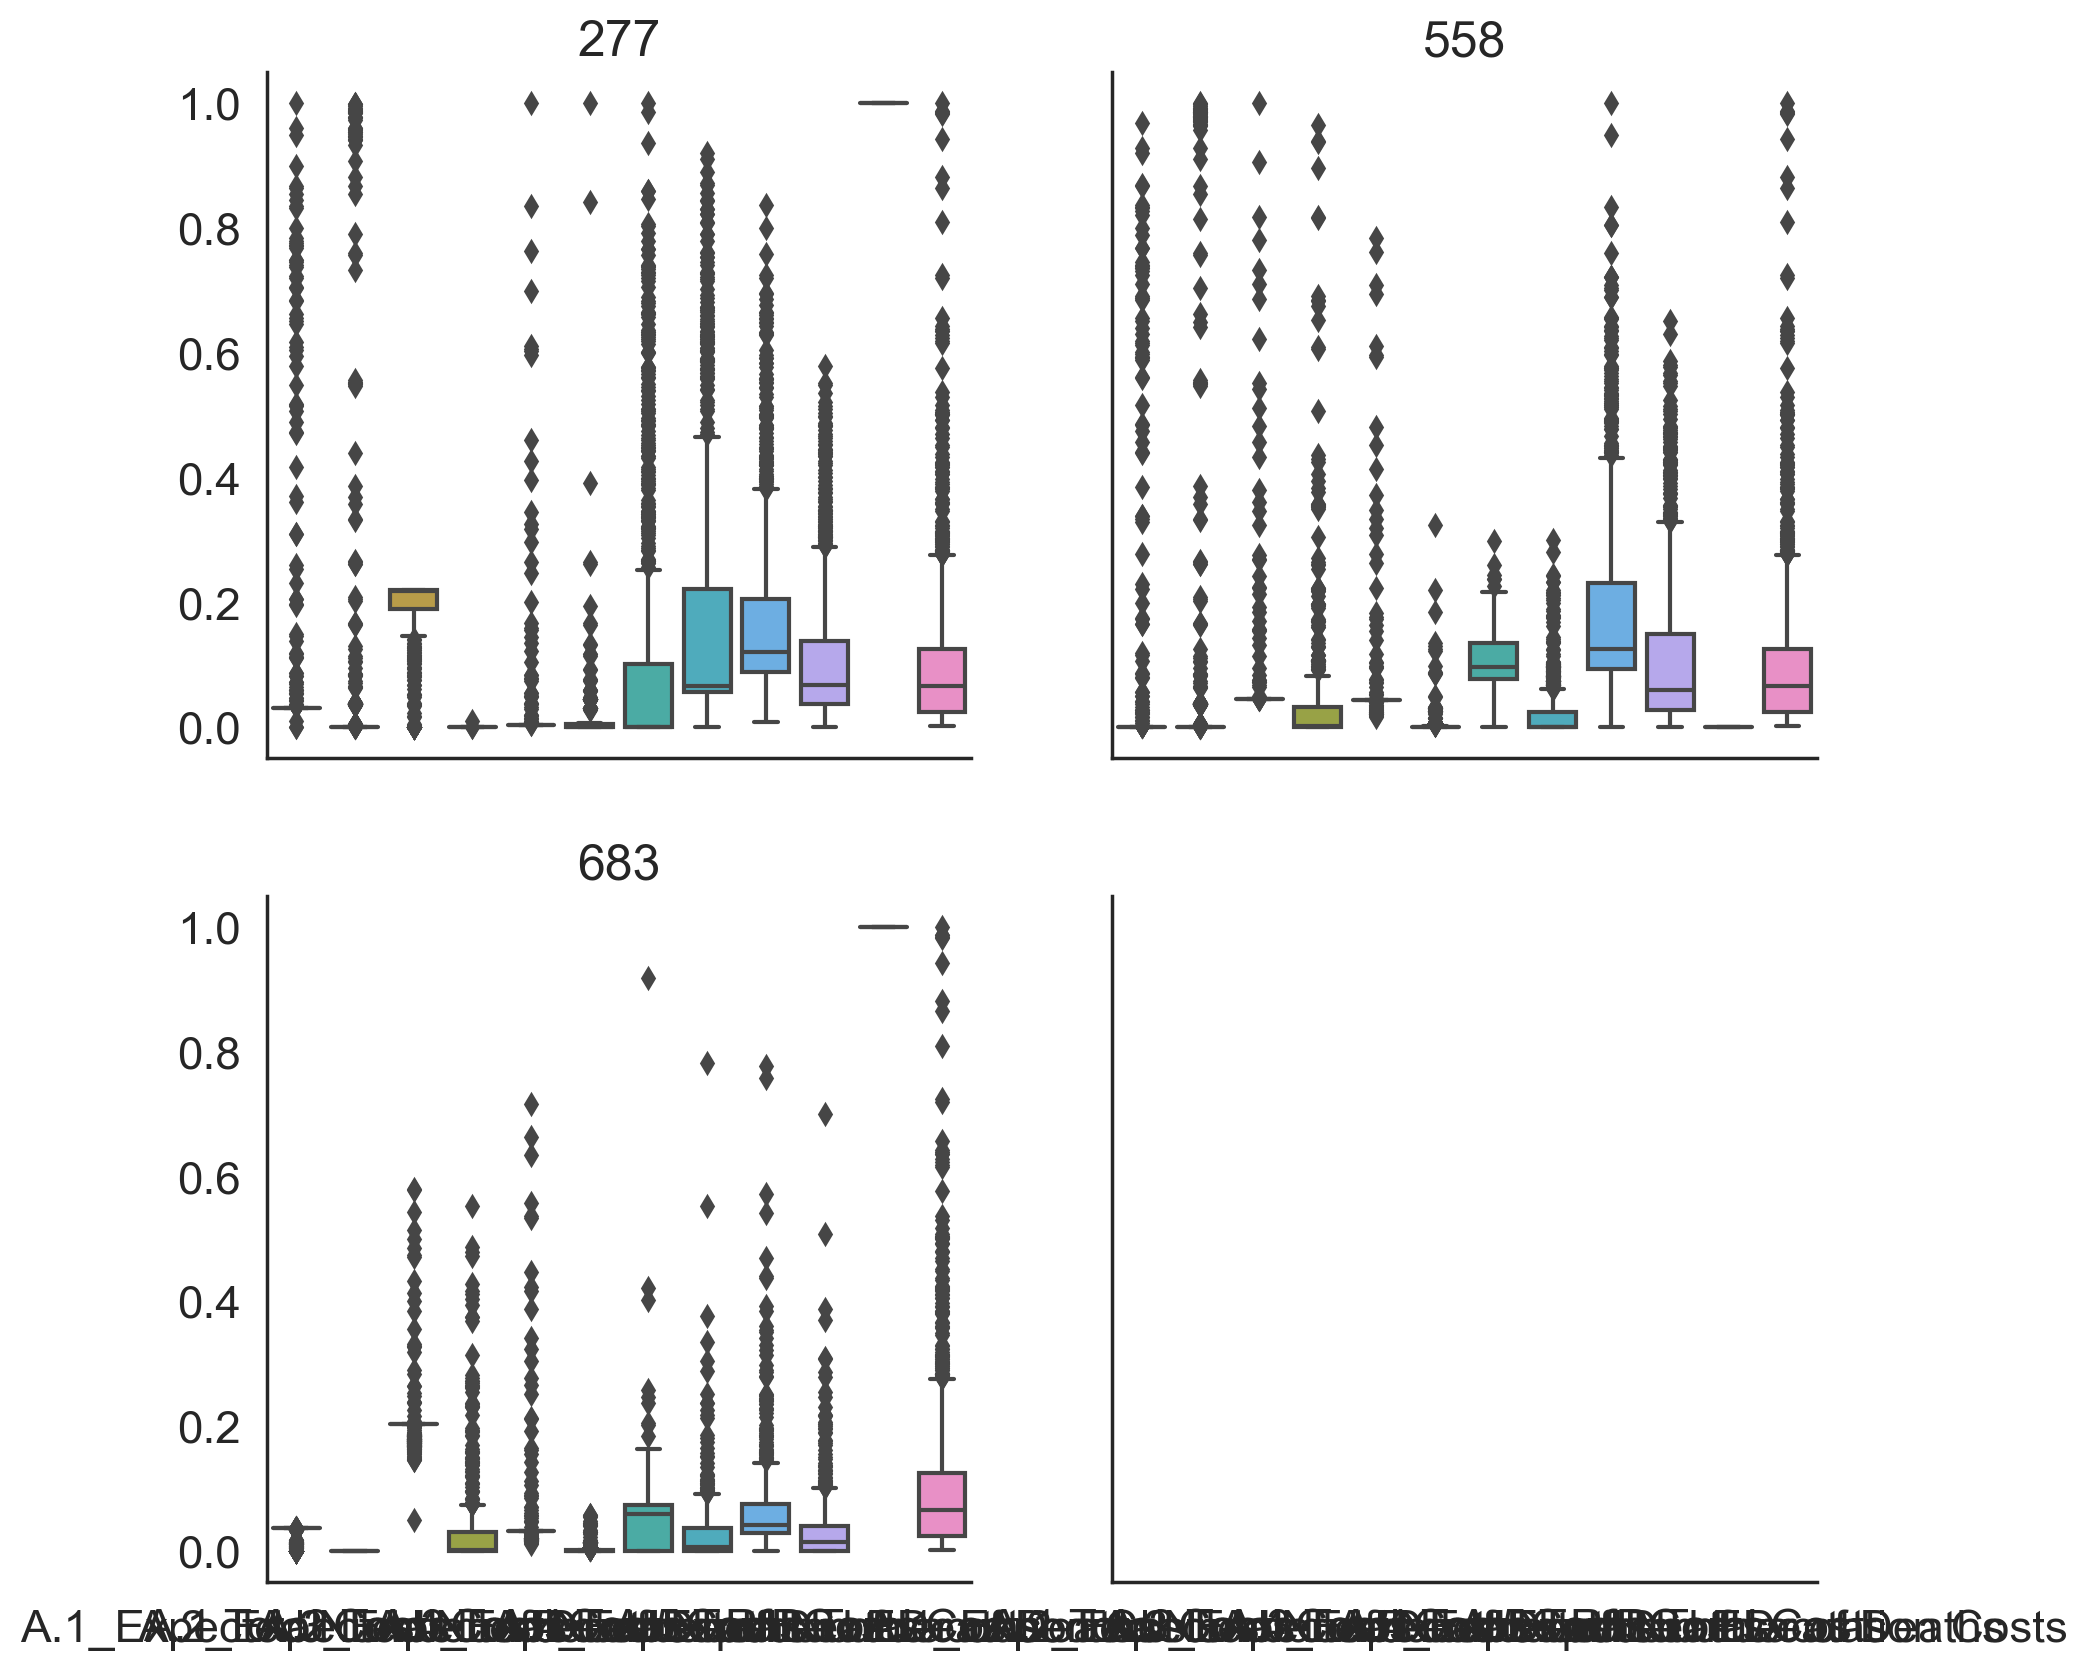

In [13]:
# this generates a 2 by 2 axes grid, with a shared X and Y axis
# accross all plots
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(10,10), 
                         sharey=True, sharex=True)

# to ensure easy iteration over the axes grid, we turn it
# into a list. Because there are four plots, I hard coded
# this. 
axes = [axes[0,0], axes[0,1],
        axes[1,0],]

# zip allows us to zip together the list of axes and the list of 
# key value pairs return by items. If we iterate over this
# it returns a tuple of length 2. The first item is the ax
# the second items is the key value pair.
for ax, (policy, regret) in zip(axes, policy_regret.items()):
    data = pd.DataFrame(regret)

    # we need to scale the regret to ensure fair visual
    # comparison. We can do that by divding by the maximum regret
    data = data/max_regret.max(axis=0)
    sns.boxplot(data=data, ax=ax)
    
    # removes top and left hand black outline of axes
    sns.despine()
    
    # ensure we know which policy the figure is for
    ax.set_title(str(policy))
plt.show()

This is in line with the maximum regret parallel coordinates plot, but we get some more details.

We now have an understanding of which solutions have decent robustness using 2 different robustness metrics. 

A related but different question is to assess the uncertain conditions under which we get poor performance. For this, we can use scenario discovery. Since we want to identify the uncertainties only, we can remove the policy and lever columns from the experiments DataFrame. 

**Perform Scenario Discovery, focussed on understanding the conditions under which utility is lower than 0.35**

In [14]:
from ema_workbench.analysis import prim

x = experiments.drop(columns=['policy', 'c1','c2', 'r1', 'r2', 'w1'])
y = outcomes['utility'] < 0.35

prim_alg = prim.Prim(x,y, threshold=0.5)
box = prim_alg.find_box()

KeyError: "['c1' 'c2' 'r1' 'r2' 'w1'] not found in axis"

In [ ]:
box.inspect_tradeoff()

the choice for box 42 is somewhat arbitrary. 

In [ ]:
box.inspect(42)

In [ ]:
box.select(42)

In [ ]:
scens_in_box = experiments.iloc[box.yi]

In [ ]:
outcomes_in_box = {k:v[box.yi] for k,v in outcomes.items()}

